# Imports

In [51]:
import pandas as pd
import numpy as np
from pycirclize import Circos
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Smetana

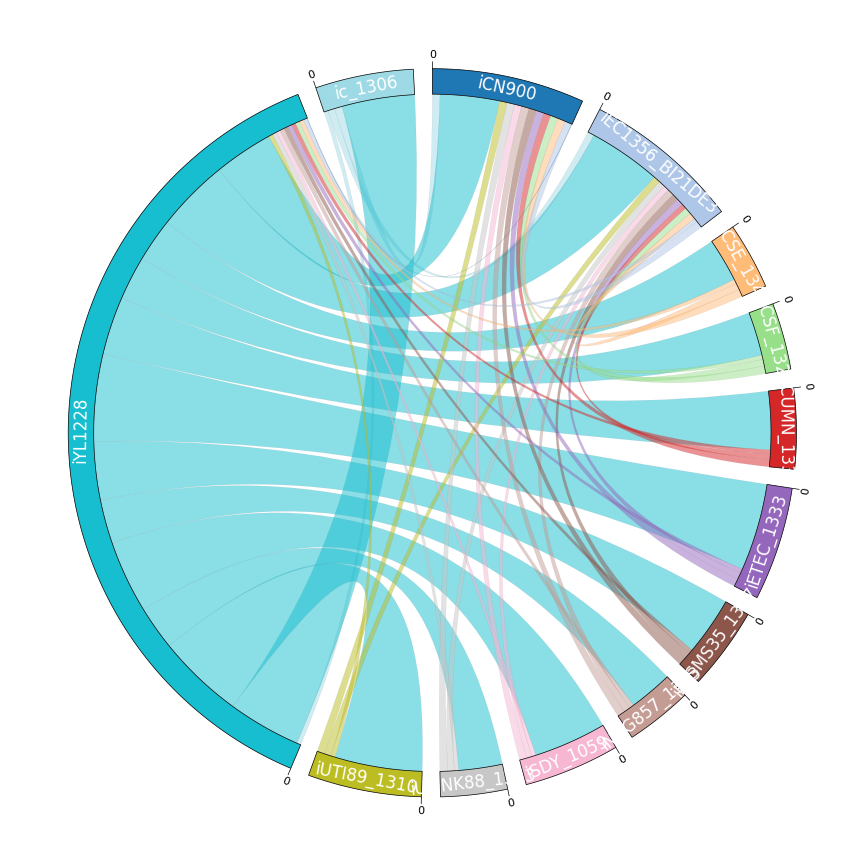

In [52]:
# Load SMETANA detailed-mode TSV file
df = pd.read_csv("/home/arog/Documents/GitHub/HGMB_Project/comm_results/smetana_all_detailed.tsv", sep="\t")

# Get unique strains from donor + receiver
strains = sorted(set(df["donor"]).union(set(df["receiver"])))

# Initialize empty matrix (donor = rows, receiver = columns)
matrix_df = pd.DataFrame(0.0, index=strains, columns=strains)

# Fill matrix with summed SMETANA scores
for _, row in df.iterrows():
    donor = row["donor"]
    receiver = row["receiver"]
    score = row["smetana"]
    matrix_df.loc[donor, receiver] += score

# OPTIONAL: Normalize scores or apply a threshold
# matrix_df = matrix_df.clip(upper=1.0)

# Build chord diagram with the template style
circos = Circos.chord_diagram(
    matrix_df,
    space=3,
    r_lim=(93, 100),
    cmap="tab20",  # more distinct colors
    ticks_interval=500,
    label_kws=dict(r=94, size=12, color="white")
)

# Plot and show
fig = circos.plotfig()
plt.show()


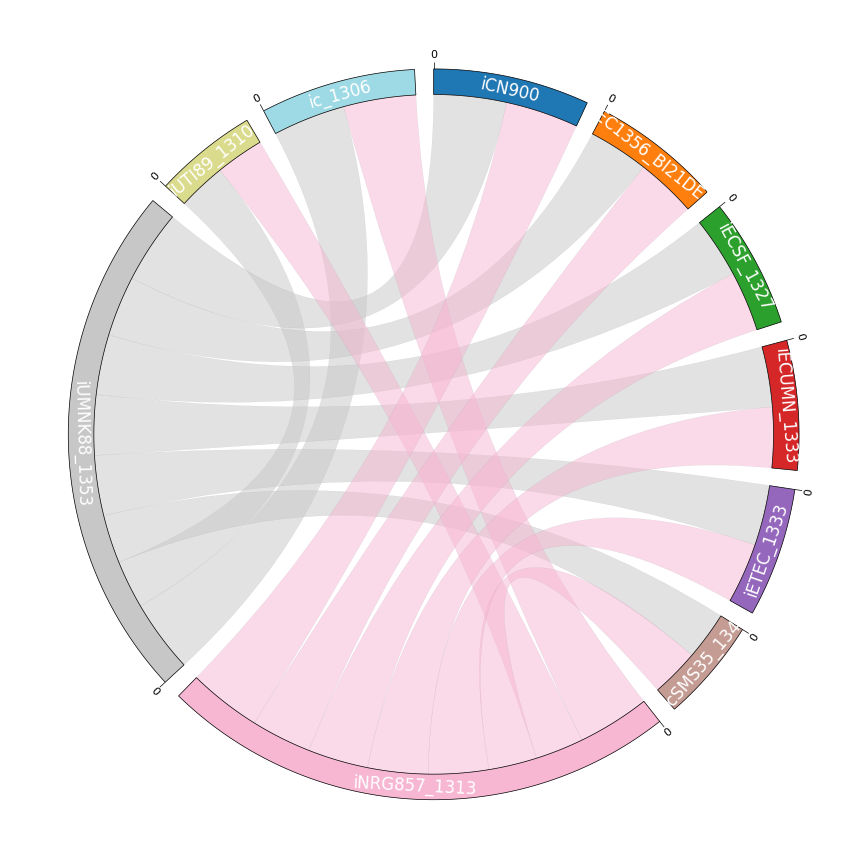

In [53]:
# Load SMETANA detailed-mode TSV file
df = pd.read_csv("/home/arog/Documents/GitHub/HGMB_Project/comm_results/smetana_healthy_detailed.tsv", sep="\t")

# Get unique strains from donor + receiver
strains = sorted(set(df["donor"]).union(set(df["receiver"])))

# Initialize empty matrix (donor = rows, receiver = columns)
matrix_df = pd.DataFrame(0.0, index=strains, columns=strains)

# Fill matrix with summed SMETANA scores
for _, row in df.iterrows():
    donor = row["donor"]
    receiver = row["receiver"]
    score = row["smetana"]
    matrix_df.loc[donor, receiver] += score

# OPTIONAL: Normalize scores or apply a threshold
# matrix_df = matrix_df.clip(upper=1.0)

# Build chord diagram with the template style
circos = Circos.chord_diagram(
    matrix_df,
    space=3,
    r_lim=(93, 100),
    cmap="tab20",  # more distinct colors
    ticks_interval=500,
    label_kws=dict(r=94, size=12, color="white")
)

# Plot and show
fig = circos.plotfig()
plt.show()

# Micom

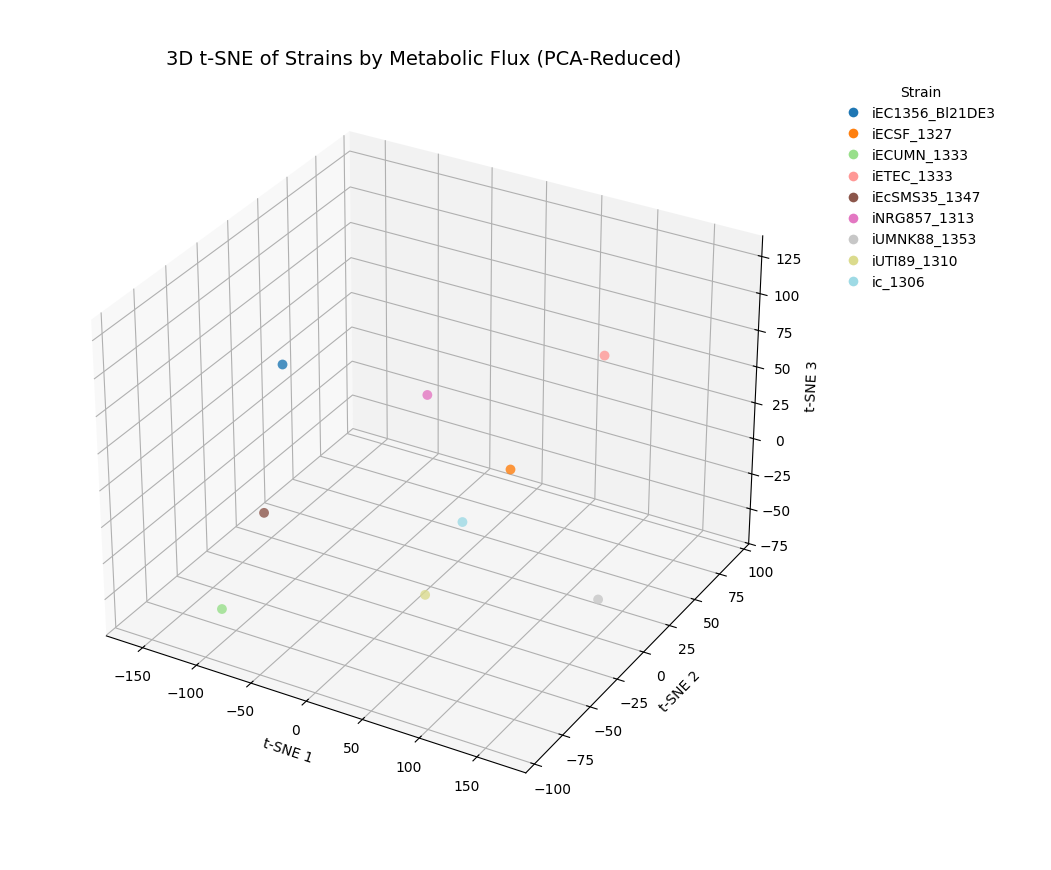

In [71]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load dataset
df = pd.read_csv("/home/arog/Documents/GitHub/HGMB_Project/comm_results/fluxes_MICOM.csv", sep=";", index_col=0)
df = df.drop(index='medium', errors='ignore')  # Safer drop

# Sample labels
sample_labels = df.index.to_list()

# Keep only numeric columns (fluxes)
flux_data = df.select_dtypes(include=[np.number]).fillna(0.0)

# Filter reactions with significant total flux
threshold = 1e-6
filtered_fluxes = flux_data.loc[:, flux_data.abs().sum(axis=0) > threshold]
if filtered_fluxes.empty:
    raise ValueError("No reactions passed the flux threshold. Adjust threshold.")

# Standardize
X_scaled = StandardScaler().fit_transform(filtered_fluxes)

# PCA: Keep 95% variance or max 50 components
pca = PCA(n_components=0.95)  # Adjust as needed
X_pca = pca.fit_transform(X_scaled)

# t-SNE: Adjust perplexity based on sample size
perplexity = min(5, len(X_pca) - 1)  # Cap at 30
X_tsne = TSNE(n_components=3, perplexity=perplexity, random_state=42).fit_transform(X_pca)

# Encode strain labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(sample_labels)

# 3D Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2],
    c=encoded_labels, cmap='tab20', s=50, alpha=0.8, edgecolor='k'
)

ax.set_title("3D t-SNE of Strains by Metabolic Flux (PCA-Reduced)", fontsize=14)
ax.set_xlabel("t-SNE 1"); ax.set_ylabel("t-SNE 2"); ax.set_zlabel("t-SNE 3")

# Legend (skip if too many strains)
if len(label_encoder.classes_) <= 20:
    legend_labels = label_encoder.classes_
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', label=lbl,
                   markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=8)
        for i, lbl in enumerate(legend_labels)
    ]
    ax.legend(handles=legend_handles, title="Strain", bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()



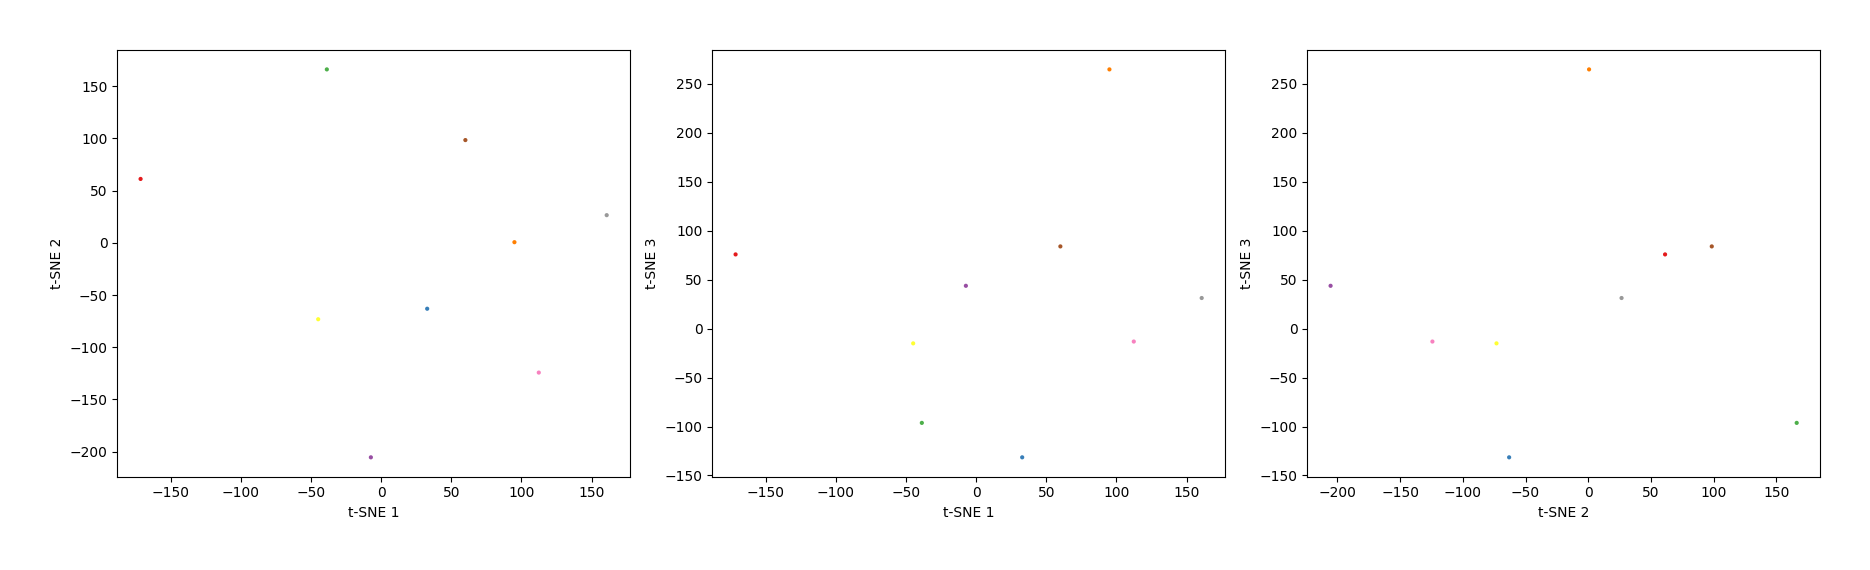

In [65]:
# Add this after your 3D plot to show 2D projections
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
projections = [(0,1), (0,2), (1,2)]
for ax, (i,j) in zip(axes, projections):
    ax.scatter(X_tsne[:, i], X_tsne[:, j], c=encoded_labels, cmap='Set1')
    ax.set_xlabel(f"t-SNE {i+1}")
    ax.set_ylabel(f"t-SNE {j+1}")
plt.tight_layout()

In [56]:
# Add explained variance ratio for PCA
print(f"PCA explained variance: {PCA().fit(X_scaled).explained_variance_ratio_[:n_pca_components].sum():.2%}")

PCA explained variance: 100.00%


# Fluxes

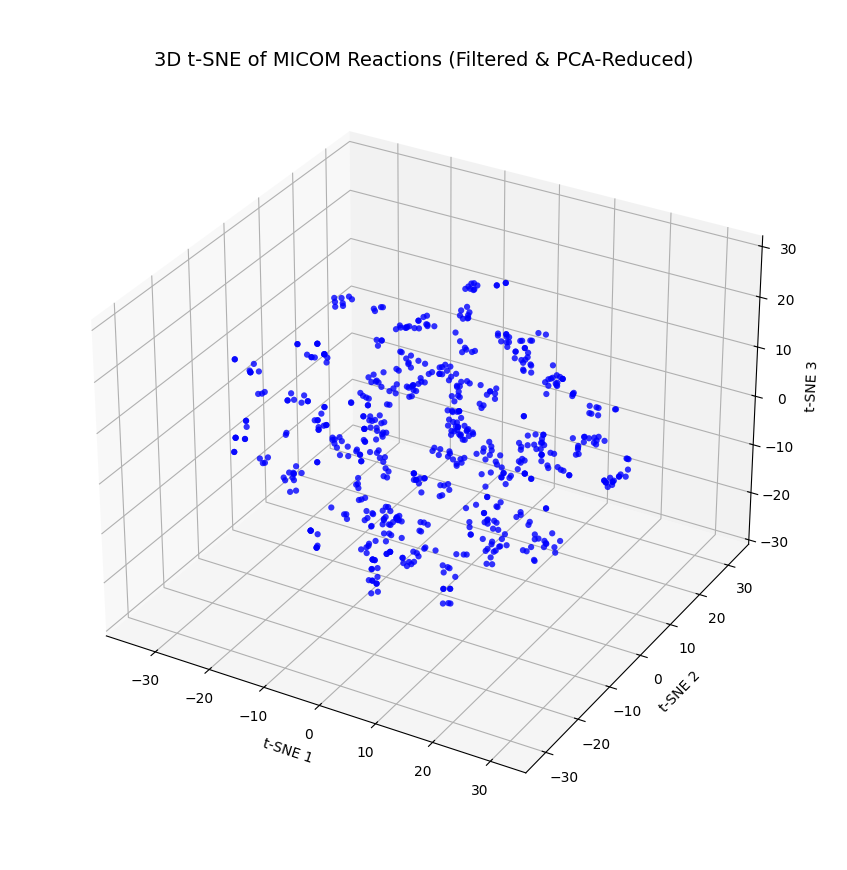

In [57]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load and clean MICOM flux dataset
df = pd.read_csv("/home/arog/Documents/GitHub/HGMB_Project/comm_results/fluxes_MICOM.csv", sep=";", index_col=0)
df = df.drop(index='medium', errors='ignore')

# Keep only numeric values and transpose
flux_data = df.select_dtypes(include=[np.number]).fillna(0.0)
flux_data_T = flux_data.T  # reactions as rows

# Apply variance filter across strains (axis=0), keeping high-variance reactions
selector = VarianceThreshold(threshold=1e-10)
filtered = selector.fit_transform(flux_data)  # NOT transposed

# Get reaction IDs from columns
filtered_reaction_labels = flux_data.columns[selector.get_support()].to_list()

# Transpose: now rows = reactions
filtered_flux_data = pd.DataFrame(filtered, index=flux_data.index, columns=filtered_reaction_labels).T

# Standardize
X_scaled = StandardScaler().fit_transform(filtered_flux_data)

# PCA
n_pca_components = min(10, X_scaled.shape[1])
X_pca = PCA(n_components=n_pca_components).fit_transform(X_scaled)

# t-SNE
X_tsne = TSNE(n_components=3, perplexity=5, random_state=42).fit_transform(X_pca)

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2],
                     c='blue', s=20, alpha=0.8)

ax.set_title("3D t-SNE of MICOM Reactions (Filtered & PCA-Reduced)", fontsize=14)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")

plt.tight_layout()
plt.show()



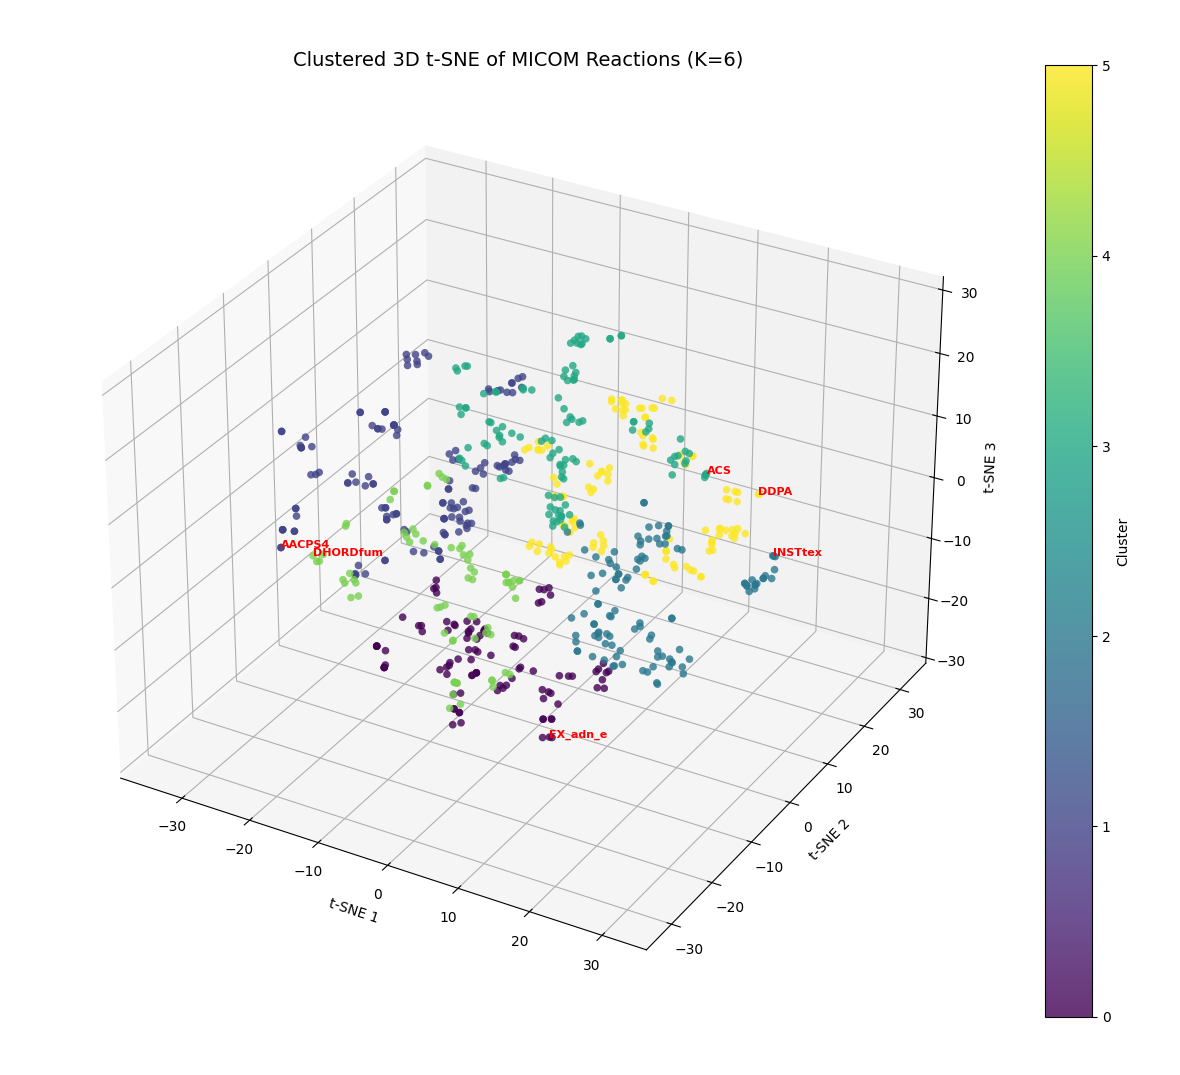

Analysis complete. Results saved to 'clustered_tsne_results.csv'.


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- Load your existing t-SNE results (or rerun if needed) ---
# X_tsne = ... (from your previous script)
# filtered_reaction_labels = ... (from your previous script)

# --- Step 1: Cluster Reactions using K-means ---
# Optimize cluster number using silhouette score
best_n_clusters = 3  # Default; adjust if needed
if len(X_tsne) > 2:  # Ensure enough samples for clustering
    silhouette_scores = []
    for n in range(2, min(10, len(X_tsne))):
        kmeans = KMeans(n_clusters=n, random_state=42).fit(X_tsne)
        score = silhouette_score(X_tsne, kmeans.labels_)
        silhouette_scores.append(score)
    best_n_clusters = np.argmax(silhouette_scores) + 2  # +2 because range starts at 2

kmeans = KMeans(n_clusters=best_n_clusters, random_state=42).fit(X_tsne)
cluster_labels = kmeans.labels_

# --- Step 2: Plot Clustered 3D t-SNE ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2],
    c=cluster_labels, cmap='viridis', s=30, alpha=0.8, edgecolor='k'
)
ax.set_title(f"Clustered 3D t-SNE of MICOM Reactions (K={best_n_clusters})", fontsize=14)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
plt.colorbar(scatter, label='Cluster')

# --- Step 3: Annotate Top Reactions in Each Cluster ---
# Identify reactions farthest from cluster centroids (potential key drivers)
for cluster_id in range(best_n_clusters):
    cluster_mask = (cluster_labels == cluster_id)
    cluster_points = X_tsne[cluster_mask]
    centroid = kmeans.cluster_centers_[cluster_id]
    
    # Calculate distances to centroid
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    top_reaction_idx = np.argmax(distances)  # Farthest point = potential outlier/key reaction
    
    # Get the original reaction ID
    original_idx = np.where(cluster_mask)[0][top_reaction_idx]
    reaction_id = filtered_reaction_labels[original_idx]
    
    # Annotate on plot
    ax.text(
        X_tsne[original_idx, 0], X_tsne[original_idx, 1], X_tsne[original_idx, 2],
        reaction_id, fontsize=8, color='red', weight='bold'
    )

plt.tight_layout()
plt.show()

# --- Step 4: Save Results for Downstream Analysis ---
# Create a DataFrame with reactions, clusters, and coordinates
results_df = pd.DataFrame({
    'Reaction': filtered_reaction_labels,
    'Cluster': cluster_labels,
    'tSNE1': X_tsne[:, 0],
    'tSNE2': X_tsne[:, 1],
    'tSNE3': X_tsne[:, 2]
})
results_df.to_csv("clustered_tsne_results.csv", index=False)

print("Analysis complete. Results saved to 'clustered_tsne_results.csv'.")

# SteadyComm